<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 3663, '日付': '2022-05-17T08:00:00.000Z'},
 {'小計': 4355, '日付': '2022-05-18T08:00:00.000Z'},
 {'小計': 4172, '日付': '2022-05-19T08:00:00.000Z'},
 {'小計': 3573, '日付': '2022-05-20T08:00:00.000Z'},
 {'小計': 3464, '日付': '2022-05-21T08:00:00.000Z'},
 {'小計': 3317, '日付': '2022-05-22T08:00:00.000Z'},
 {'小計': 2025, '日付': '2022-05-23T08:00:00.000Z'},
 {'小計': 3271, '日付': '2022-05-24T08:00:00.000Z'},
 {'小計': 3929, '日付': '2022-05-25T08:00:00.000Z'},
 {'小計': 3391, '日付': '2022-05-26T08:00:00.000Z'},
 {'小計': 2630, '日付': '2022-05-27T08:00:00.000Z'},
 {'小計': 2549, '日付': '2022-05-28T08:00:00.000Z'},
 {'小計': 2194, '日付': '2022-05-29T08:00:00.000Z'},
 {'小計': 1344, '日付': '2022-05-30T08:00:00.000Z'},
 {'小計': 2362, '日付': '2022-05-31T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2022-05-27 17:00:00+09:00,252,0,2630,2022-05-27 17:00:00+09:00
2022-05-28 17:00:00+09:00,260,0,2549,2022-05-28 17:00:00+09:00
2022-05-29 17:00:00+09:00,197,0,2194,2022-05-29 17:00:00+09:00
2022-05-30 17:00:00+09:00,257,0,1344,2022-05-30 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2022-05-27 17:00:00+09:00,252,0,2630,2022-05-27 17:00:00+09:00,272.142857,1905.0,0.0,0.0,3146.714286,22027.0
2022-05-28 17:00:00+09:00,260,0,2549,2022-05-28 17:00:00+09:00,261.142857,1828.0,0.0,0.0,3016.000000,21112.0
2022-05-29 17:00:00+09:00,197,0,2194,2022-05-29 17:00:00+09:00,252.000000,1764.0,0.0,0.0,2855.571429,19989.0
2022-05-30 17:00:00+09:00,257,0,1344,2022-05-30 17:00:00+09:00,245.857143,1721.0,0.0,0.0,2758.285714,19308.0
2022-05-31 17:00:00+09:00,0,0,2362,2022-05-31 17:00:00+09:00,205.857143,1441.0,0.0,0.0,2628.428571,18399.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2022-05-17 17:00:00+09:00,264,0,3663,2022-05-17 17:00:00+09:00,306.714286,2147.0,0.0,0.0,3753.714286,26276.0,'22w20,Tue
2022-05-18 17:00:00+09:00,312,0,4355,2022-05-18 17:00:00+09:00,306.857143,2148.0,0.0,0.0,3695.285714,25867.0,'22w20,Wed
2022-05-19 17:00:00+09:00,276,0,4172,2022-05-19 17:00:00+09:00,302.857143,2120.0,0.0,0.0,3689.000000,25823.0,'22w20,Thu
2022-05-20 17:00:00+09:00,271,0,3573,2022-05-20 17:00:00+09:00,299.428571,2096.0,0.0,0.0,3612.428571,25287.0,'22w20,Fri
2022-05-21 17:00:00+09:00,337,0,3464,2022-05-21 17:00:00+09:00,292.857143,2050.0,0.0,0.0,3564.571429,24952.0,'22w20,Sat
2022-05-22 17:00:00+09:00,261,0,3317,2022-05-22 17:00:00+09:00,291.857143,2043.0,0.0,0.0,3560.142857,24921.0,'22w20,Sun
2022-05-23 17:00:00+09:00,300,0,2025,2022-05-23 17:00:00+09:00,288.714286,2021.0,0.0,0.0,3509.857143,24569.0,'22w21,Mon
2022-05-24 17:00:00+09:00,280,0,3271,2022-05-24 17:00:00+09:00,291.000000,2037.0,0.0,0.0,3453.857143,24177.0,'22w21,Tue
2022-05-25 17:00:00+09:00,234,0,3929,2022-05-25 17:00:00+09:00,279.857143,1959.0,0.0,0.0,3393.000000,23751.0,'22w21,Wed
2022-05-26 17:00:00+09:00,241,0,3391,2022-05-26 17:00:00+09:00,274.857143,1924.0,0.0,0.0,3281.428571,22970.0,'22w21,Thu


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2022-05-15 17:00:00+09:00,3956.857143,27698
2022-05-22 17:00:00+09:00,3560.142857,24921
2022-05-29 17:00:00+09:00,2855.571429,19989
2022-05-31 17:00:00+09:00,1853.000000,3706
2022-01-02 17:00:00+09:00,80.000000,160


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2022-05-17 17:00:00+09:00,264,0,3663,2022-05-17 17:00:00+09:00,306.714286,2147.0,0.0,0.0,3753.714286,26276.0,'22w20,Tue,NaN,NaN
2022-05-18 17:00:00+09:00,312,0,4355,2022-05-18 17:00:00+09:00,306.857143,2148.0,0.0,0.0,3695.285714,25867.0,'22w20,Wed,NaN,NaN
2022-05-19 17:00:00+09:00,276,0,4172,2022-05-19 17:00:00+09:00,302.857143,2120.0,0.0,0.0,3689.000000,25823.0,'22w20,Thu,NaN,NaN
2022-05-20 17:00:00+09:00,271,0,3573,2022-05-20 17:00:00+09:00,299.428571,2096.0,0.0,0.0,3612.428571,25287.0,'22w20,Fri,NaN,NaN
2022-05-21 17:00:00+09:00,337,0,3464,2022-05-21 17:00:00+09:00,292.857143,2050.0,0.0,0.0,3564.571429,24952.0,'22w20,Sat,NaN,NaN
2022-05-22 17:00:00+09:00,261,0,3317,2022-05-22 17:00:00+09:00,291.857143,2043.0,0.0,0.0,3560.142857,24921.0,'22w20,Sun,3560.142857,24921.0
2022-05-23 17:00:00+09:00,300,0,2025,2022-05-23 17:00:00+09:00,288.714286,2021.0,0.0,0.0,3509.857143,24569.0,'22w21,Mon,NaN,NaN
2022-05-24 17:00:00+09:00,280,0,3271,2022-05-24 17:00:00+09:00,291.000000,2037.0,0.0,0.0,3453.857143,24177.0,'22w21,Tue,NaN,NaN
2022-05-25 17:00:00+09:00,234,0,3929,2022-05-25 17:00:00+09:00,279.857143,1959.0,0.0,0.0,3393.000000,23751.0,'22w21,Wed,NaN,NaN
2022-05-26 17:00:00+09:00,241,0,3391,2022-05-26 17:00:00+09:00,274.857143,1924.0,0.0,0.0,3281.428571,22970.0,'22w21,Thu,NaN,NaN


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

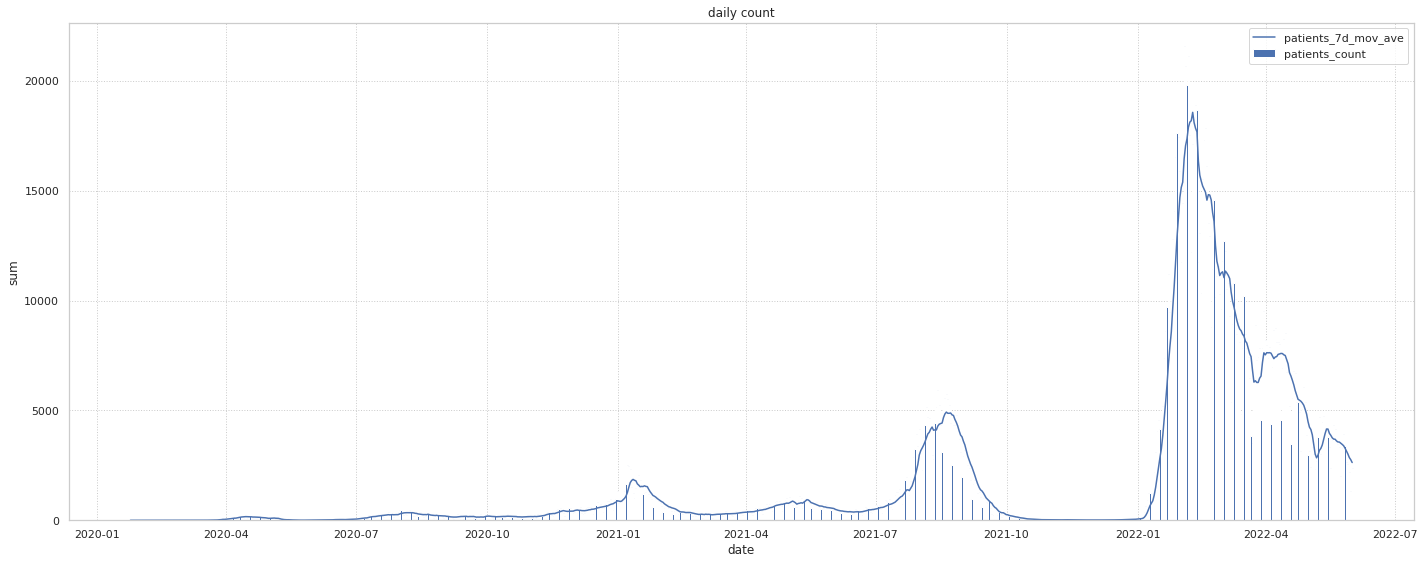

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,...,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
844,1.652774e+09,2022,5,17,0,0,0,0,0,1,...,770,264,306.714286,2147.0,0,0.0,0.0,3663,3753.714286,26276.0
845,1.652861e+09,2022,5,18,0,0,0,0,0,0,...,771,312,306.857143,2148.0,0,0.0,0.0,4355,3695.285714,25867.0
846,1.652947e+09,2022,5,19,0,0,0,0,1,0,...,772,276,302.857143,2120.0,0,0.0,0.0,4172,3689.000000,25823.0
847,1.653034e+09,2022,5,20,1,0,0,0,0,0,...,773,271,299.428571,2096.0,0,0.0,0.0,3573,3612.428571,25287.0
848,1.653120e+09,2022,5,21,0,0,1,0,0,0,...,774,337,292.857143,2050.0,0,0.0,0.0,3464,3564.571429,24952.0
849,1.653206e+09,2022,5,22,0,0,0,1,0,0,...,775,261,291.857143,2043.0,0,0.0,0.0,3317,3560.142857,24921.0
850,1.653293e+09,2022,5,23,0,1,0,0,0,0,...,776,300,288.714286,2021.0,0,0.0,0.0,2025,3509.857143,24569.0
851,1.653379e+09,2022,5,24,0,0,0,0,0,1,...,777,280,291.000000,2037.0,0,0.0,0.0,3271,3453.857143,24177.0
852,1.653466e+09,2022,5,25,0,0,0,0,0,0,...,778,234,279.857143,1959.0,0,0.0,0.0,3929,3393.000000,23751.0
853,1.653552e+09,2022,5,26,0,0,0,0,1,0,...,779,241,274.857143,1924.0,0,0.0,0.0,3391,3281.428571,22970.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 859 entries, 0 to 858
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            859 non-null    float64
 1   year                 859 non-null    int64  
 2   month                859 non-null    int64  
 3   day                  859 non-null    int64  
 4   Fri                  859 non-null    uint8  
 5   Mon                  859 non-null    uint8  
 6   Sat                  859 non-null    uint8  
 7   Sun                  859 non-null    uint8  
 8   Thu                  859 non-null    uint8  
 9   Tue                  859 non-null    uint8  
 10  Wed                  859 non-null    uint8  
 11  passed               859 non-null    int64  
 12  emergency            859 non-null    int64  
 13  em_passed            859 non-null    int64  
 14  contacts_count       859 non-null    int64  
 15  contacts_7d_mov_ave  859 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,...,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,8.590000e+02,859.000000,859.000000,859.000000,859.00000,859.00000,859.00000,859.00000,859.000000,859.00000,...,859.000000,859.000000,859.000000,859.000000,859.000000,859.000000,859.000000,859.000000,859.000000,859.000000
mean,1.616918e+09,2020.776484,6.051222,15.818393,0.14319,0.14319,0.14319,0.14319,0.142026,0.14319,...,358.230501,668.161816,667.564083,4672.944121,429.009313,429.009313,3003.065192,1793.140861,1785.499135,12498.474971
std,2.143724e+07,0.725079,3.409117,8.829231,0.35047,0.35047,0.35047,0.35047,0.349280,0.35047,...,243.093098,540.908901,528.728121,3701.102461,756.853765,697.510314,4882.572200,3556.665366,3475.487700,24328.423660
min,1.579853e+09,2020.000000,1.000000,1.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.598386e+09,2020.000000,3.000000,8.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,...,140.500000,326.500000,329.857143,2309.000000,0.000000,0.000000,0.000000,77.000000,88.714286,621.000000
50%,1.616918e+09,2021.000000,5.000000,16.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,...,355.000000,509.000000,516.714286,3617.000000,0.000000,0.000000,0.000000,327.000000,341.571429,2391.000000
75%,1.635451e+09,2021.000000,9.000000,23.500000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,...,569.500000,794.500000,789.857143,5529.000000,766.000000,971.571429,6801.000000,1167.000000,1141.928571,7993.500000
max,1.653984e+09,2022.000000,12.000000,31.000000,1.00000,1.00000,1.00000,1.00000,1.000000,1.00000,...,784.000000,3277.000000,2723.000000,19061.000000,4060.000000,2574.142857,18019.000000,21562.000000,18562.285714,129936.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,...,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.919605,0.043686,0.014649,-0.003297,0.001649,-0.001649,-3.126439e-16,0.000820,0.003297,...,0.998964,-0.079114,-0.067610,-0.067608,-0.617099,-0.662156,-0.662156,0.547575,0.562778,0.562779
year,9.196049e-01,1.000000,-0.350877,-0.017271,-0.002328,0.002259,0.002259,2.258516e-03,-0.003364,0.002259,...,0.924359,0.024894,0.036248,0.036249,-0.607726,-0.659431,-0.659431,0.651350,0.664272,0.664273
month,4.368610e-02,-0.350877,1.000000,-0.005809,-0.002244,-0.002244,-0.010048,-6.145881e-03,0.010523,0.002633,...,0.029003,-0.253623,-0.254181,-0.254179,0.075745,0.100809,0.100809,-0.352442,-0.348660,-0.348658
day,1.464886e-02,-0.017271,-0.005809,1.000000,0.003517,0.005024,0.003517,4.270314e-03,0.000437,-0.005523,...,0.015305,0.005217,-0.006594,-0.006595,0.000946,-0.009210,-0.009210,-0.011597,-0.015527,-0.015527
Fri,-3.297170e-03,-0.002328,-0.002244,0.003517,1.000000,-0.167120,-0.167120,-1.671196e-01,-0.166326,-0.167120,...,-0.002932,-0.017109,-0.001380,-0.001379,0.023436,-0.000584,-0.000584,0.016937,-0.000745,-0.000745
Mon,1.648585e-03,0.002259,-0.002244,0.005024,-0.167120,1.000000,-0.167120,-1.671196e-01,-0.166326,-0.167120,...,0.001664,0.038549,-0.000738,-0.000738,0.094257,-0.000584,-0.000584,-0.070455,0.000086,0.000087
Sat,-1.648585e-03,0.002259,-0.010048,0.003517,-0.167120,-0.167120,1.000000,-1.671196e-01,-0.166326,-0.167120,...,-0.001400,0.046425,-0.001146,-0.001146,-0.109962,-0.000584,-0.000584,0.011770,-0.000397,-0.000397
Sun,-3.126439e-16,0.002259,-0.006146,0.004270,-0.167120,-0.167120,-0.167120,1.000000e+00,-0.166326,-0.167120,...,0.000132,-0.025551,-0.000969,-0.000969,-0.101355,-0.000584,-0.000584,-0.011015,-0.000097,-0.000097
Thu,8.203779e-04,-0.003364,0.010523,0.000437,-0.166326,-0.166326,-0.166326,-1.663259e-01,1.000000,-0.166326,...,0.000438,-0.012232,0.002601,0.002602,0.029102,0.001466,0.001466,0.033276,0.000605,0.000606
Tue,3.297170e-03,0.002259,0.002633,-0.005523,-0.167120,-0.167120,-0.167120,-1.671196e-01,-0.166326,1.000000,...,0.003196,-0.018763,-0.000738,-0.000738,0.037282,-0.000584,-0.000584,-0.010365,0.000409,0.000409


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
854,1.653638e+09,1,0,0,0,0,0,0,854,0,780,252,0,2630,3146.714286,22027.0
855,1.653725e+09,0,0,1,0,0,0,0,855,0,781,260,0,2549,3016.000000,21112.0
856,1.653811e+09,0,0,0,1,0,0,0,856,0,782,197,0,2194,2855.571429,19989.0
857,1.653898e+09,0,1,0,0,0,0,0,857,0,783,257,0,1344,2758.285714,19308.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
854,1.653638e+09,854,0,2630,3146.714286,22027.0
855,1.653725e+09,855,0,2549,3016.000000,21112.0
856,1.653811e+09,856,0,2194,2855.571429,19989.0
857,1.653898e+09,857,0,1344,2758.285714,19308.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

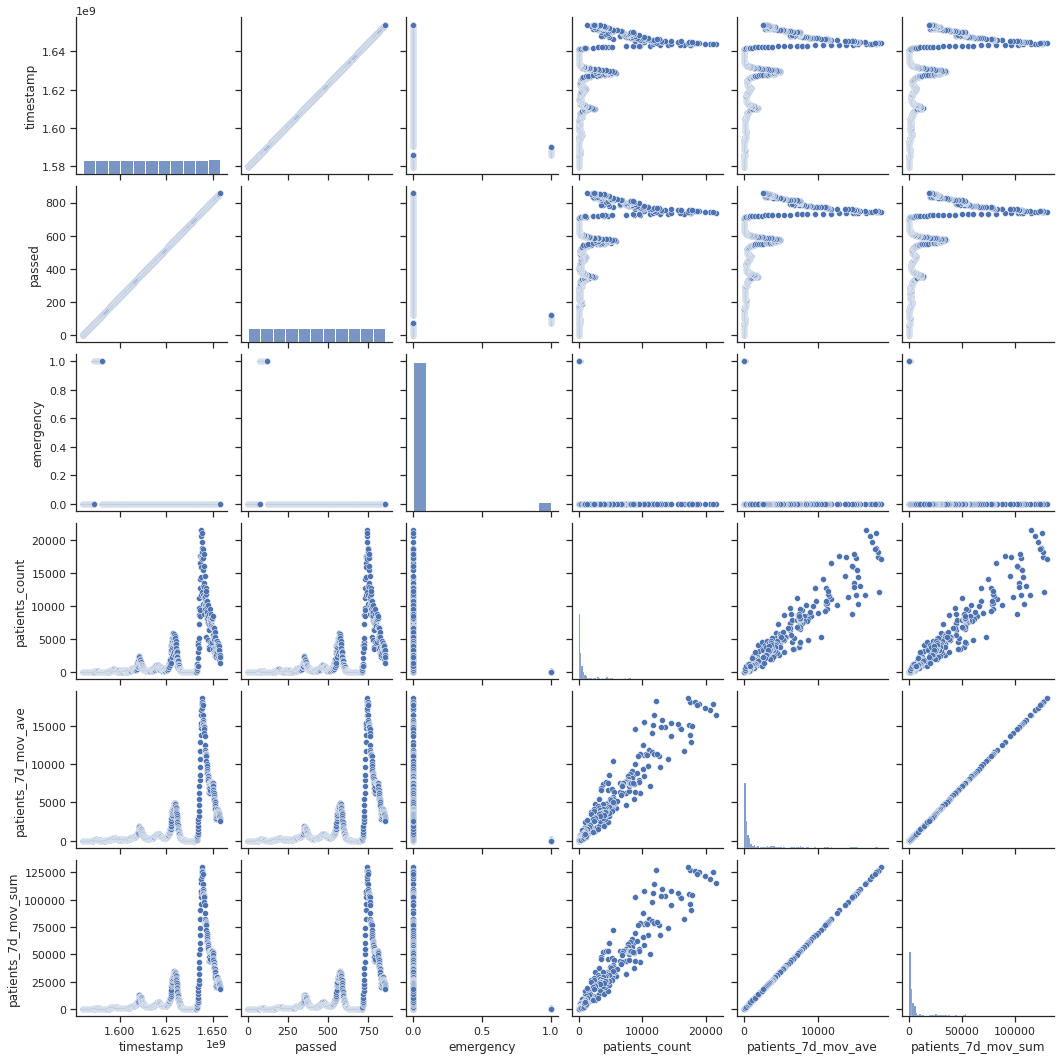

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.13


In [30]:
!pip freeze

absl-py==1.0.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.12.1
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.4.0
audioread==2.1.9
autograd==1.4
Babel==2.10.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==5.0.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.4
branca==0.5.0
bs4==0.0.1
CacheControl==0.12.11
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2022.5.18.1
cffi==1.15.0
cftime==1.6.0
chardet==3.0.4
charset-normalizer==2.0.12
click==7.1.2
cloudpickle==1.3.0
cmake==3.22.4
cmdstanpy==0.9.5
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.30
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.5.1
distribu